Imports

In [312]:
import pandas as pd
import numpy as np
from os import listdir
from os.path import join
from plotnine import *

Specify the path of the directory containing simulation results.

In [98]:
results_path = r"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\Pop_4000\Config_2_4000"
results_files = [join(results_path,f) for f in listdir(results_path)]

In [3]:
cs = [
"#ff3939",
"#d42f9a",
"#9f21d3",
"#4800ff"]

Create Scatter Plots

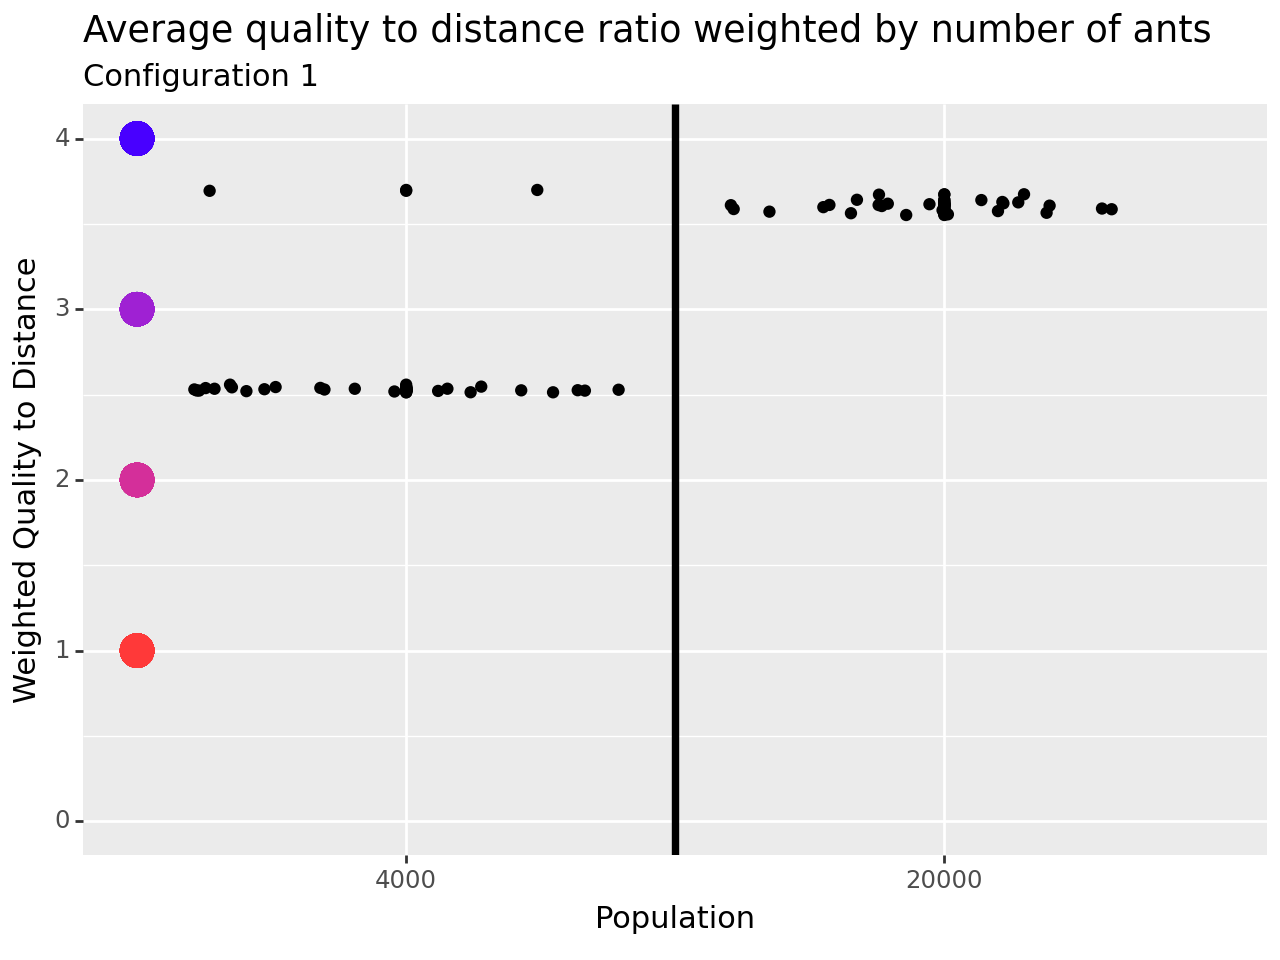

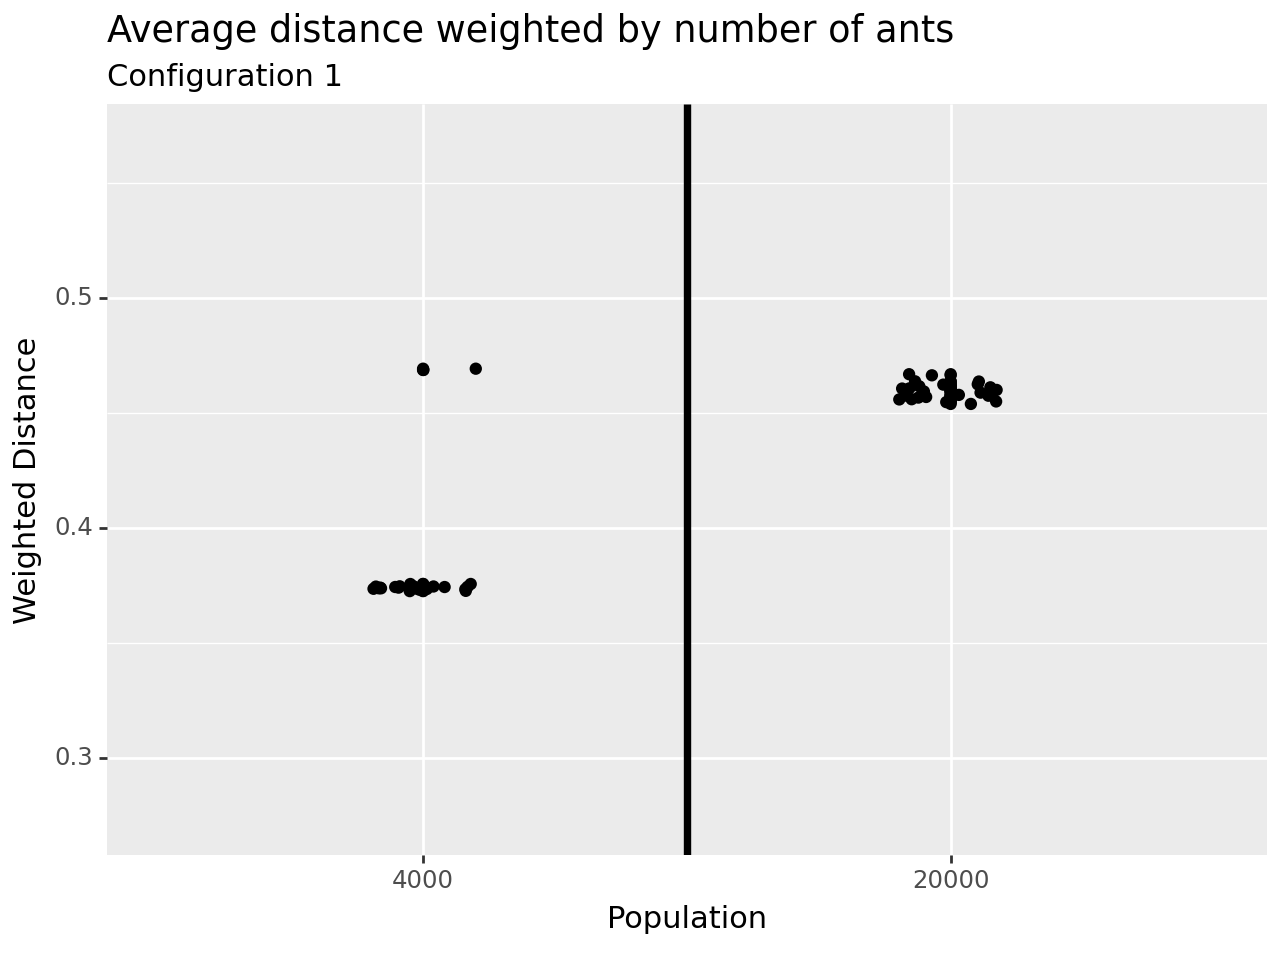

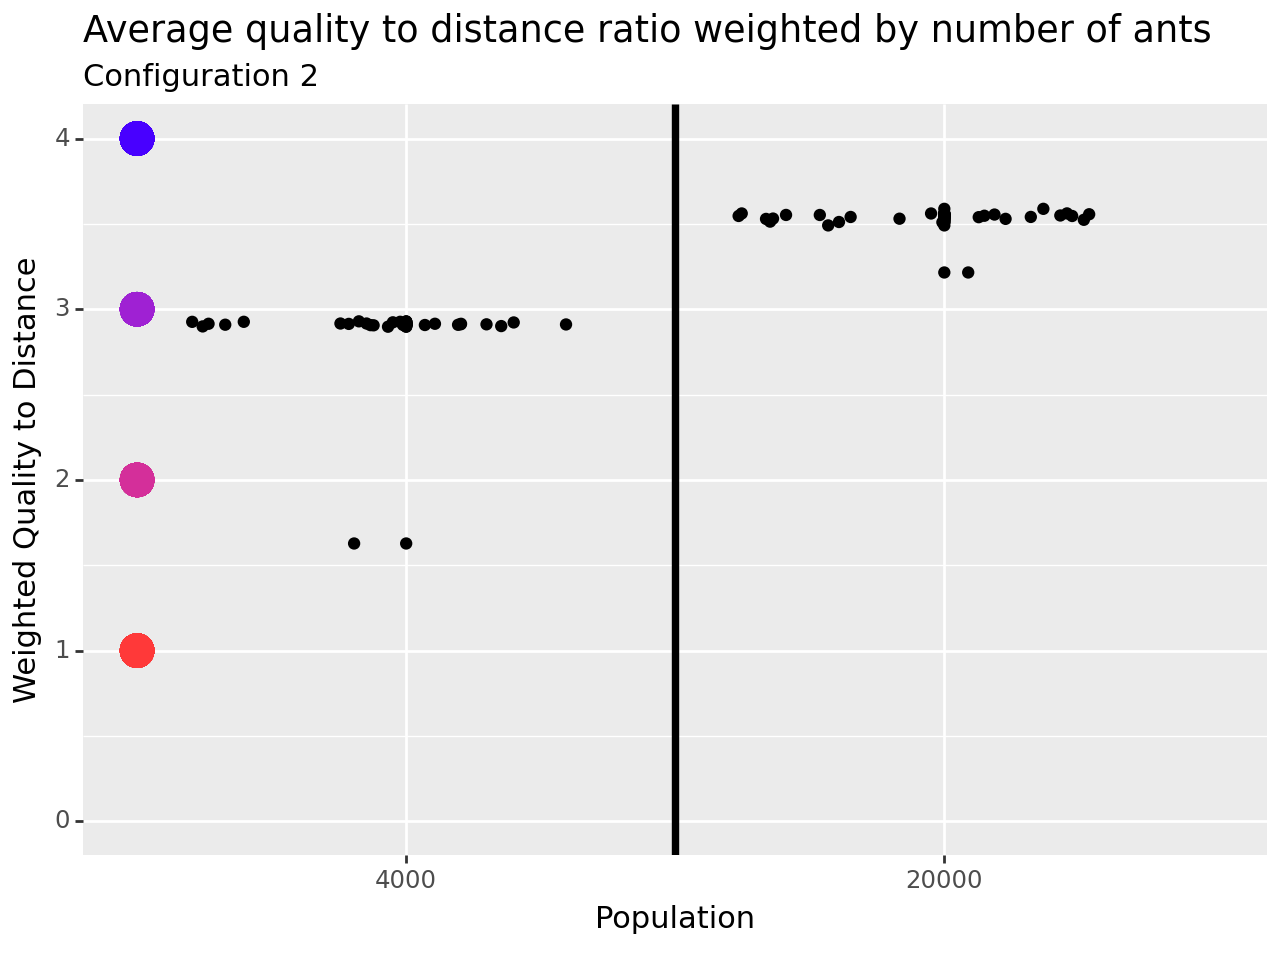

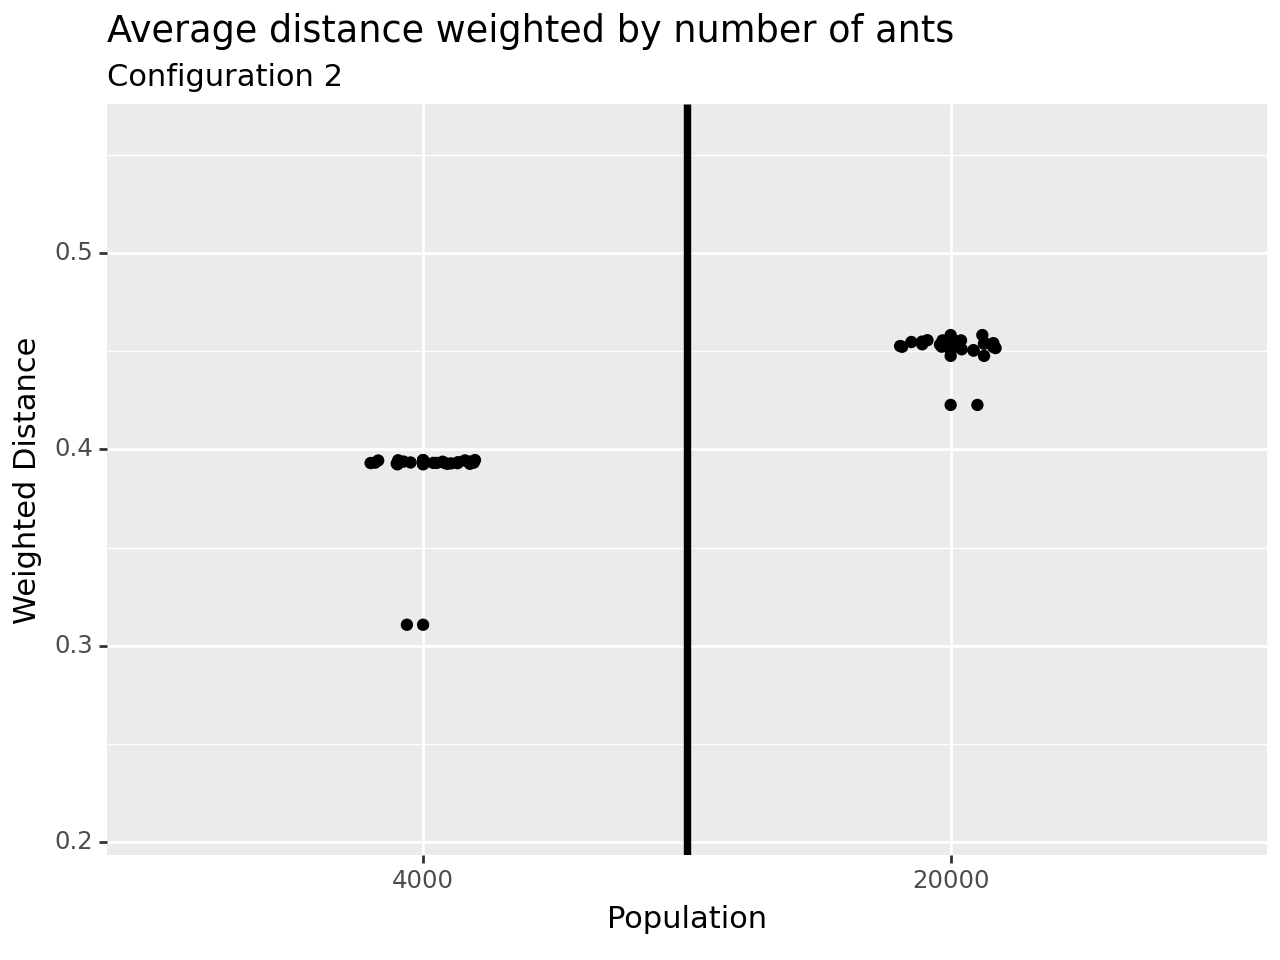

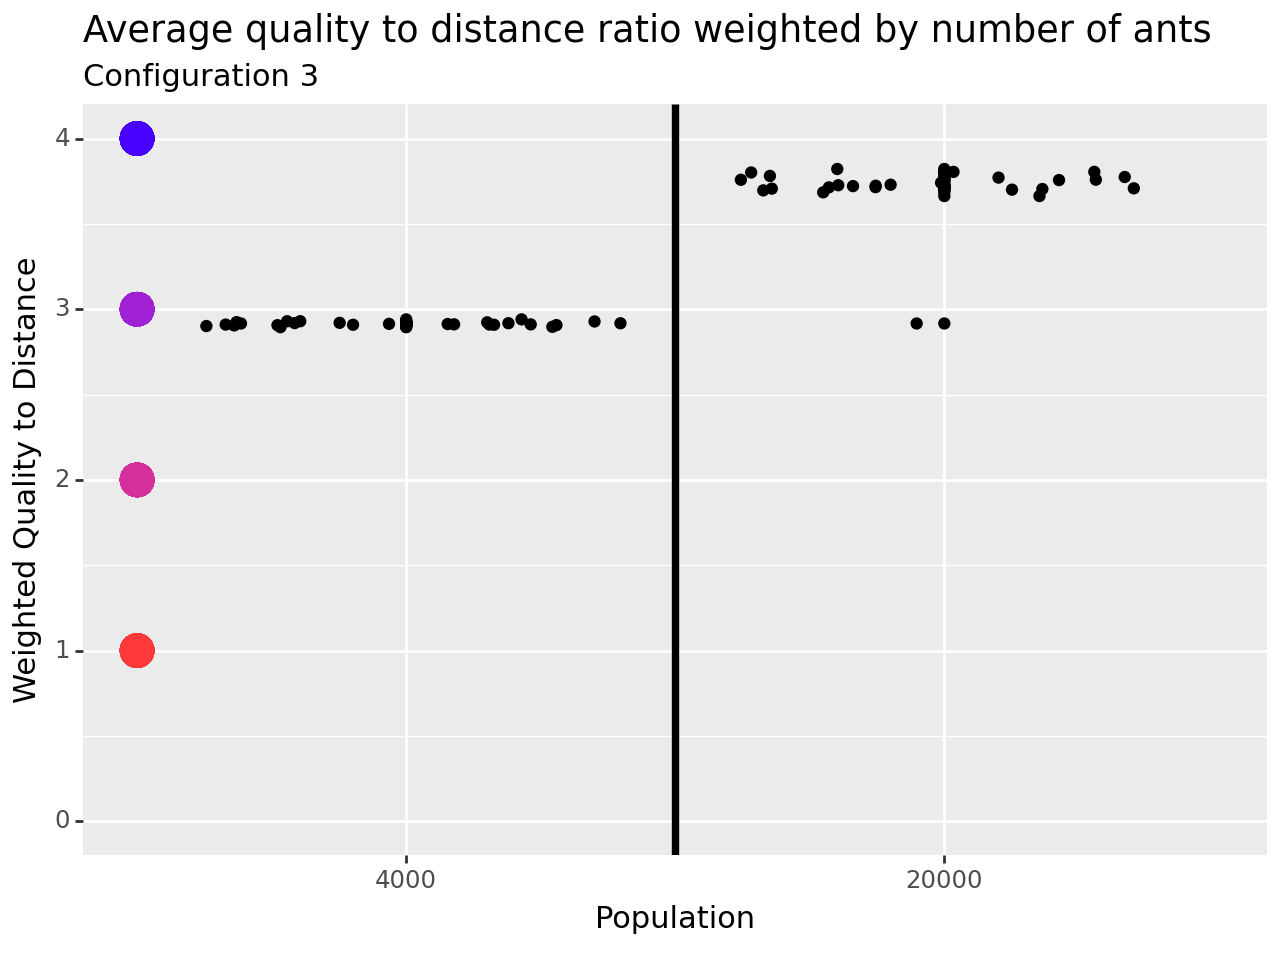

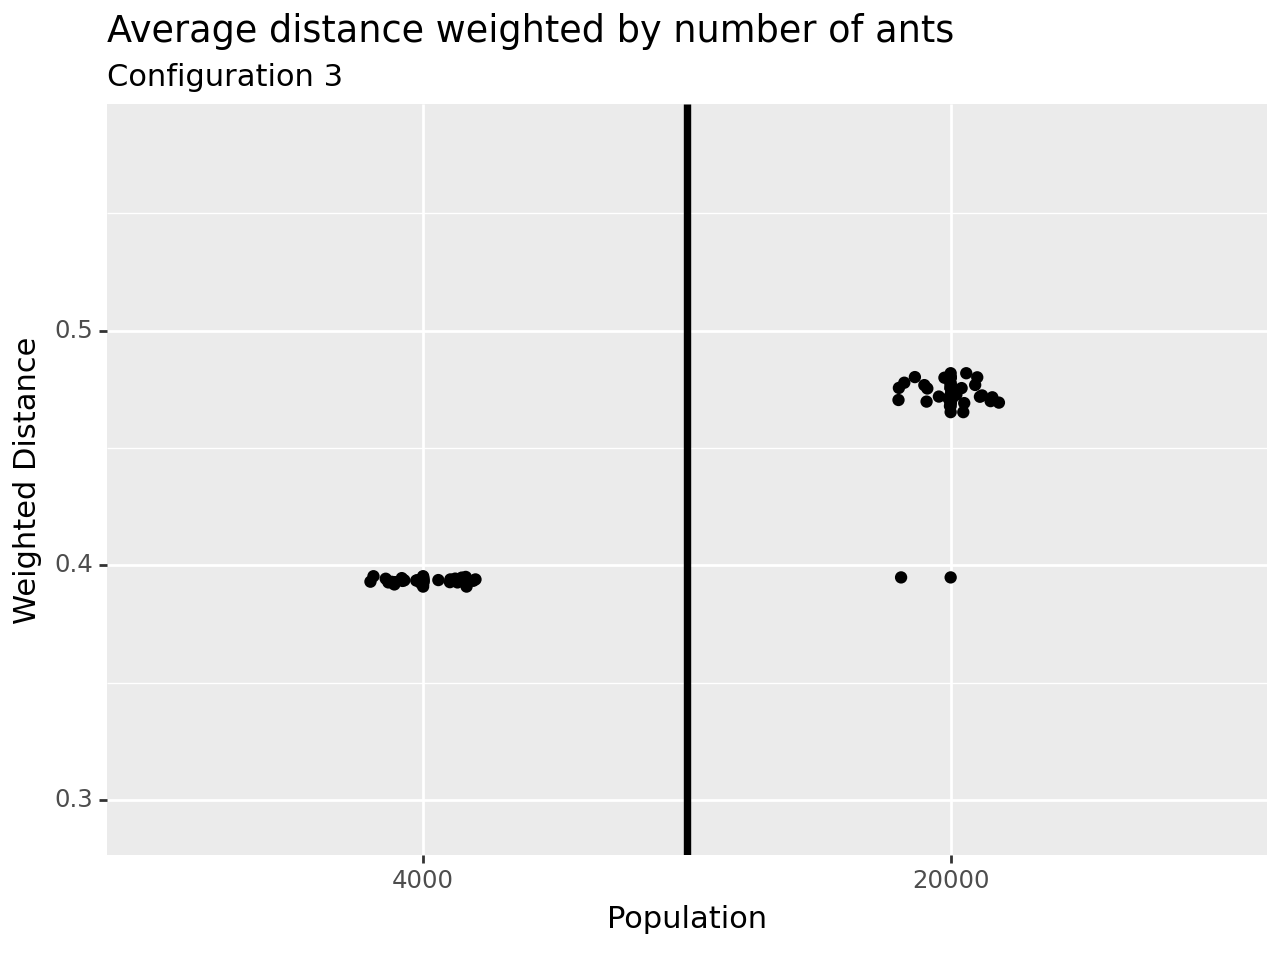

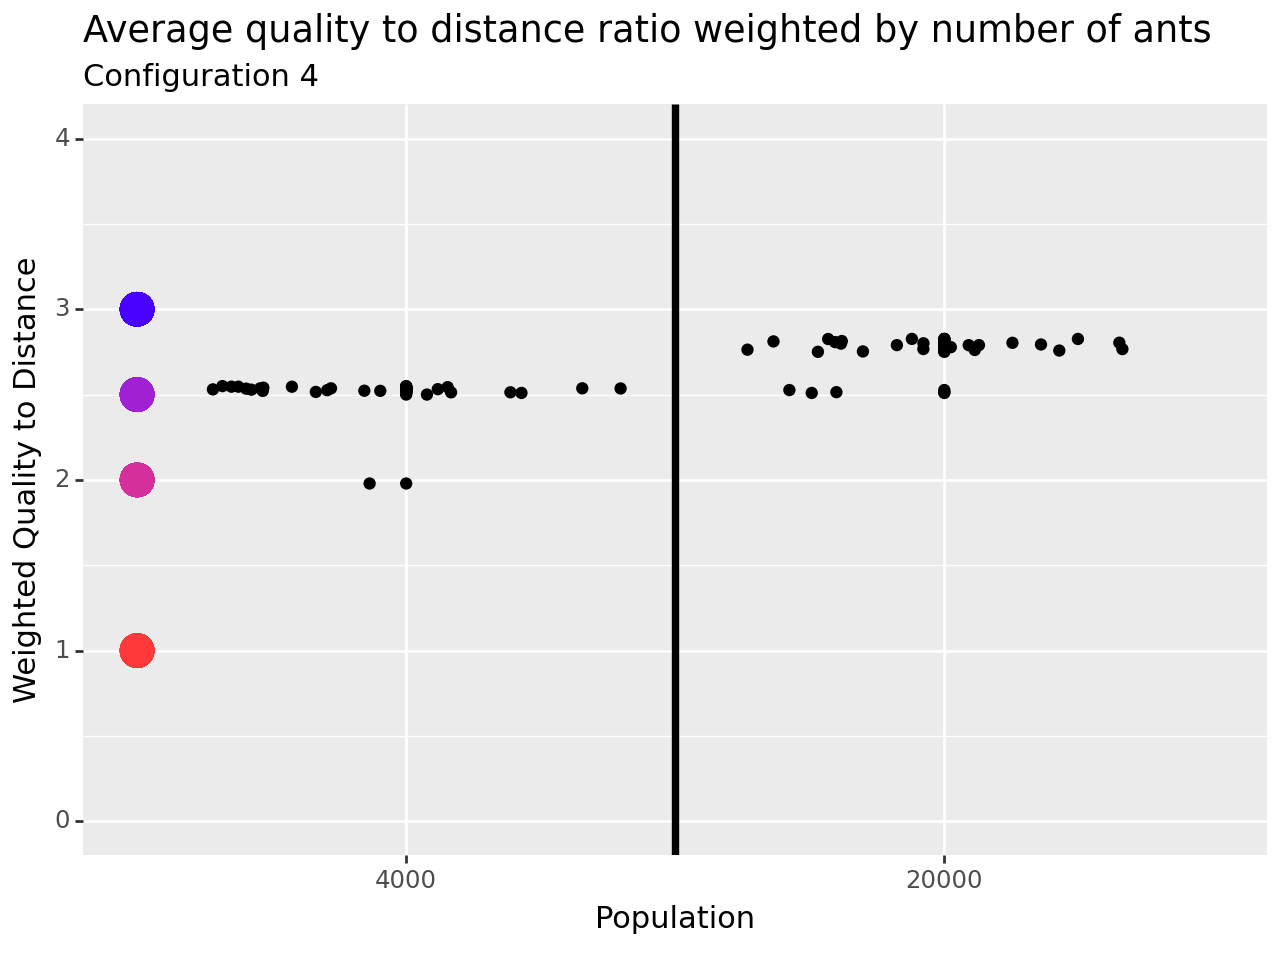

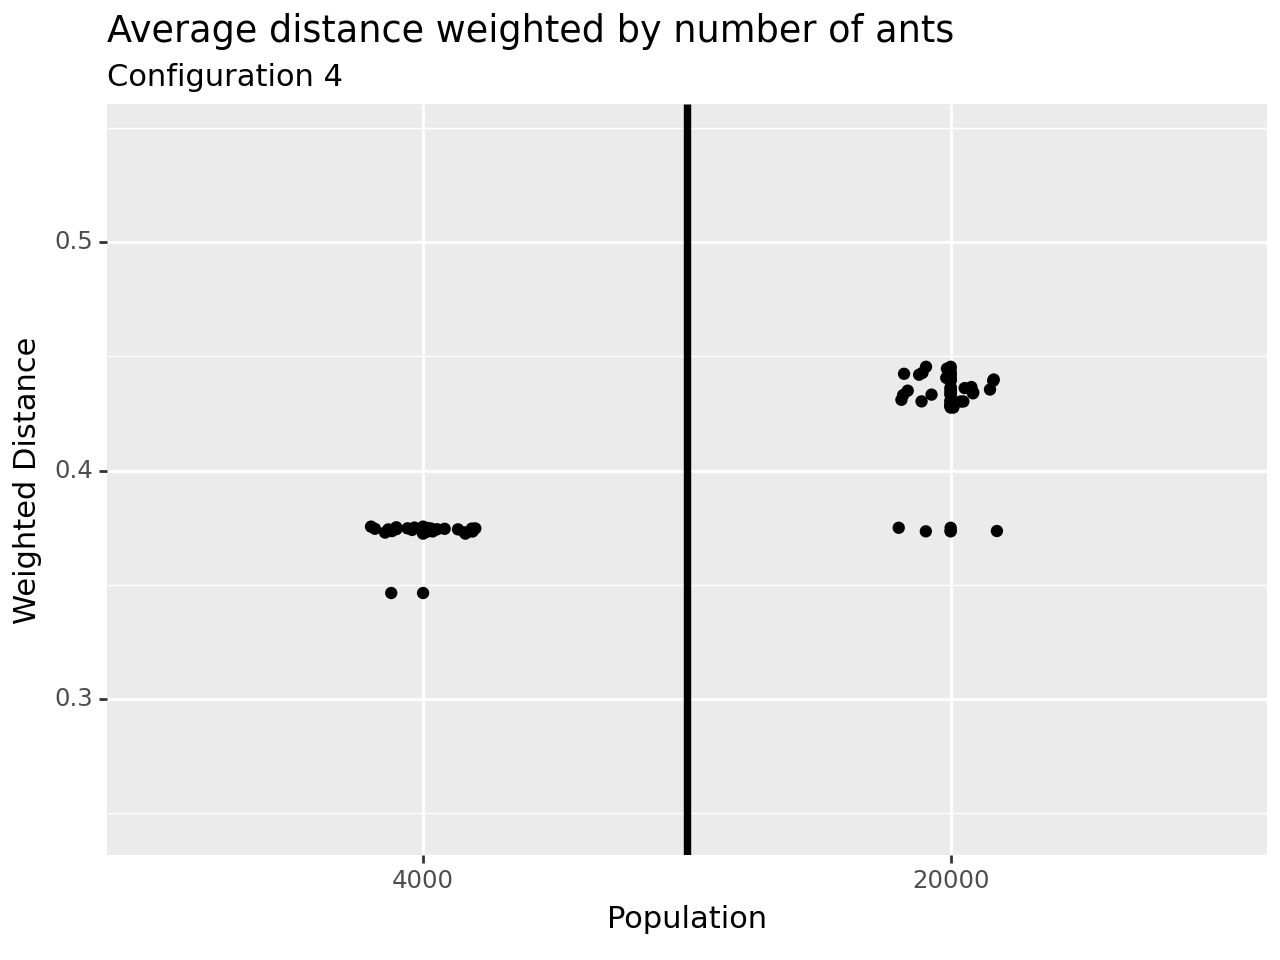

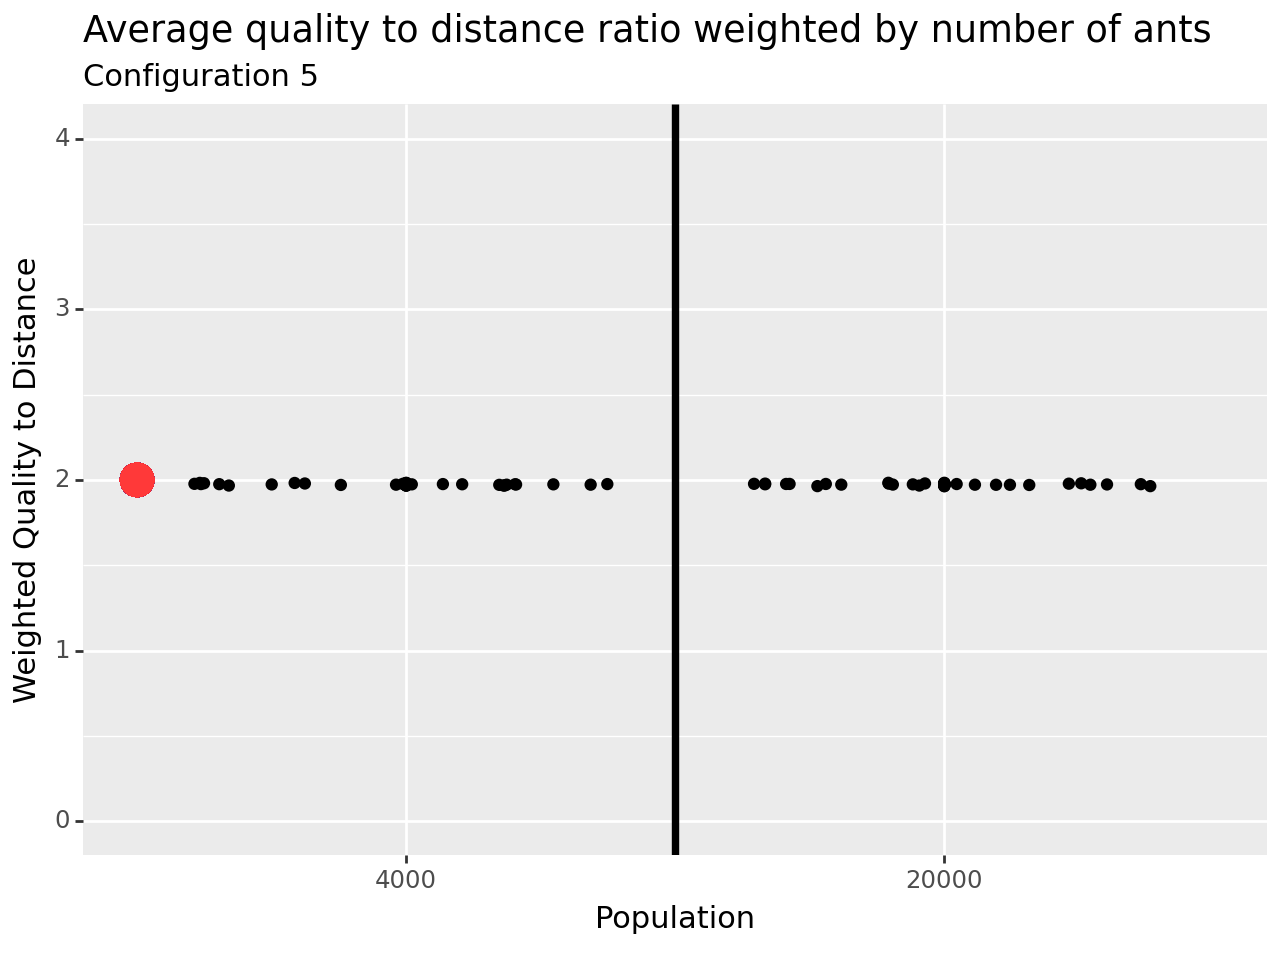

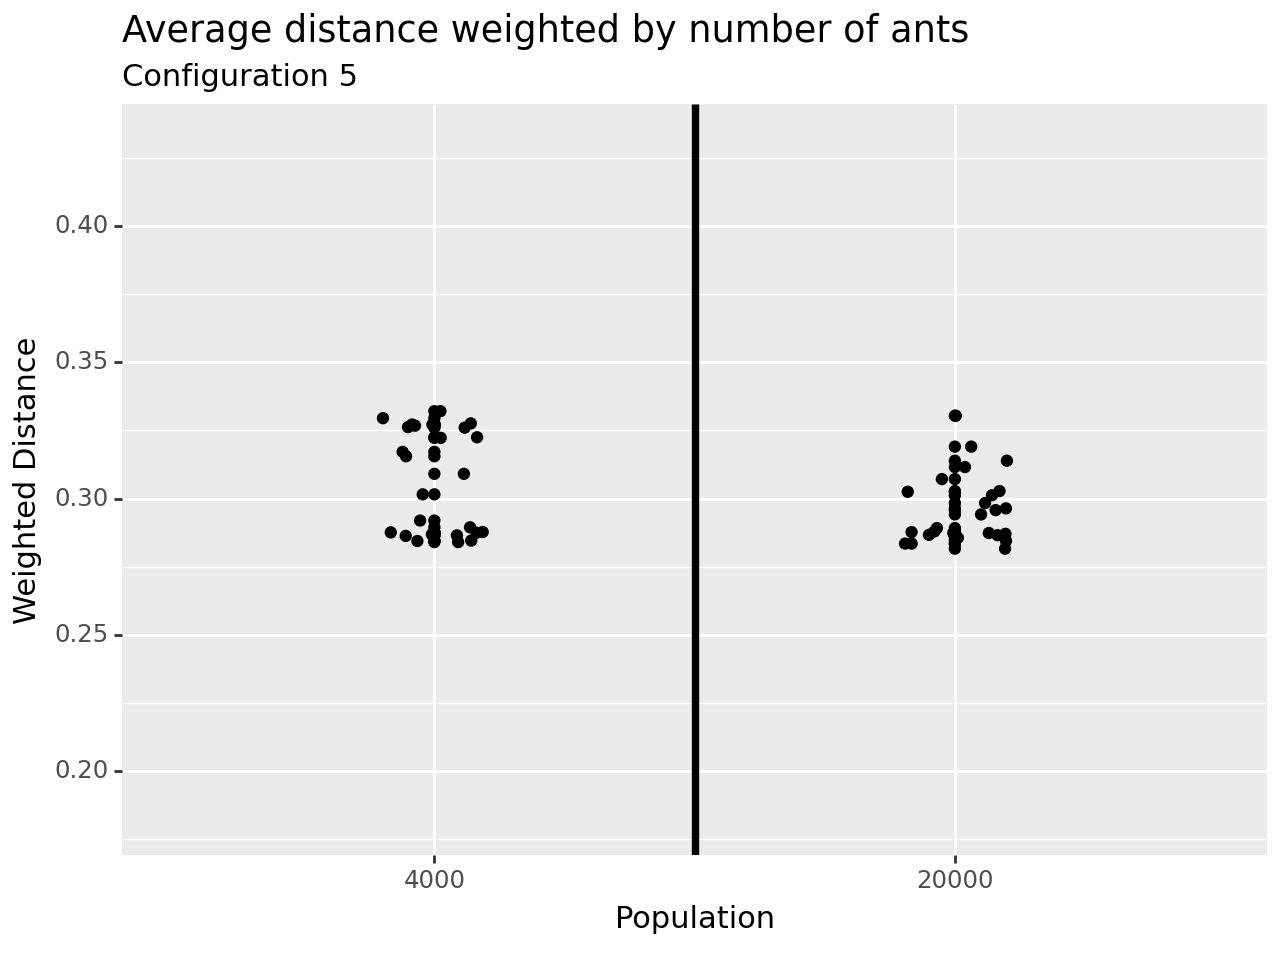

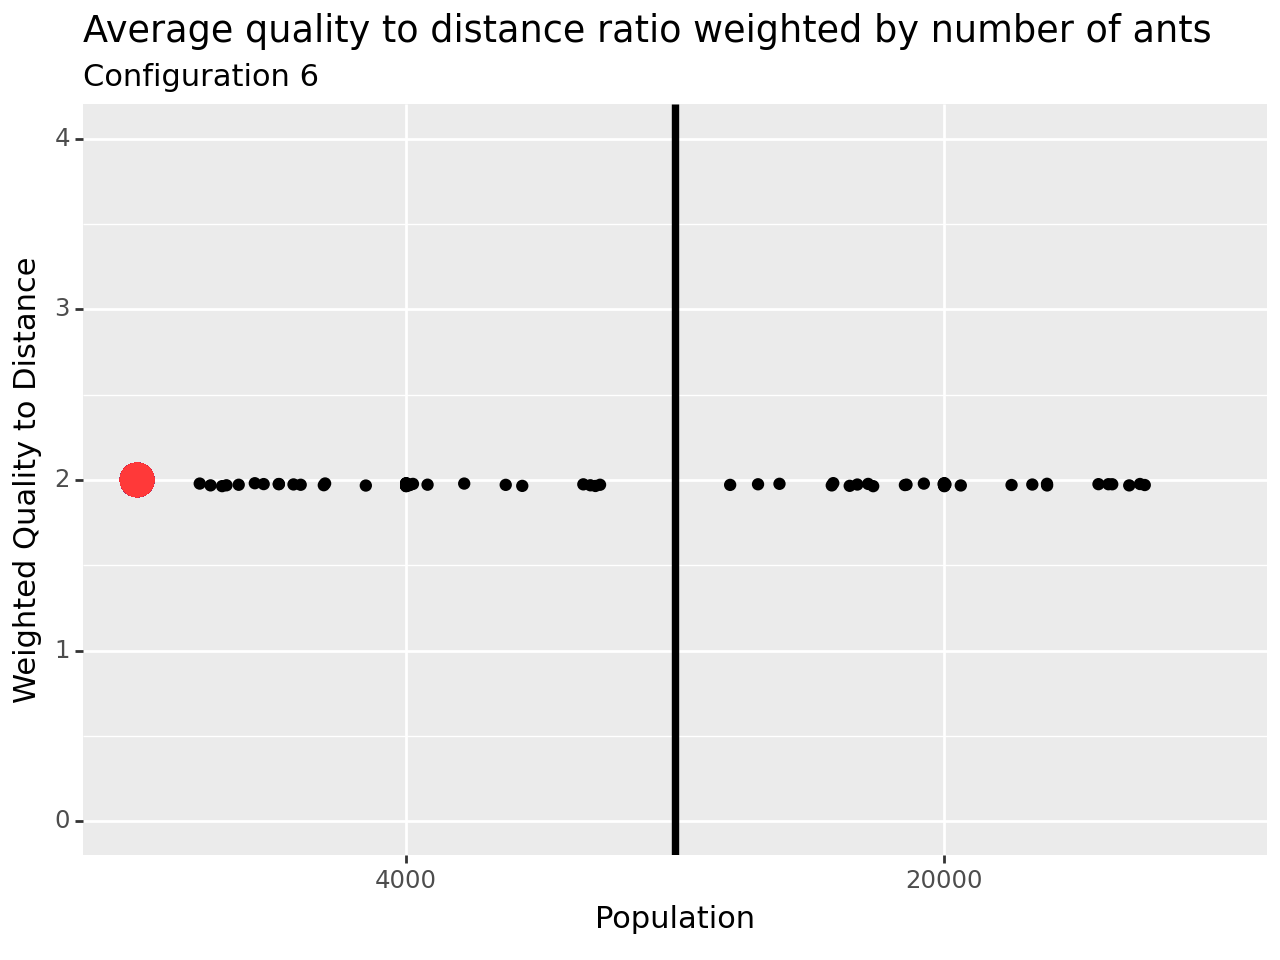

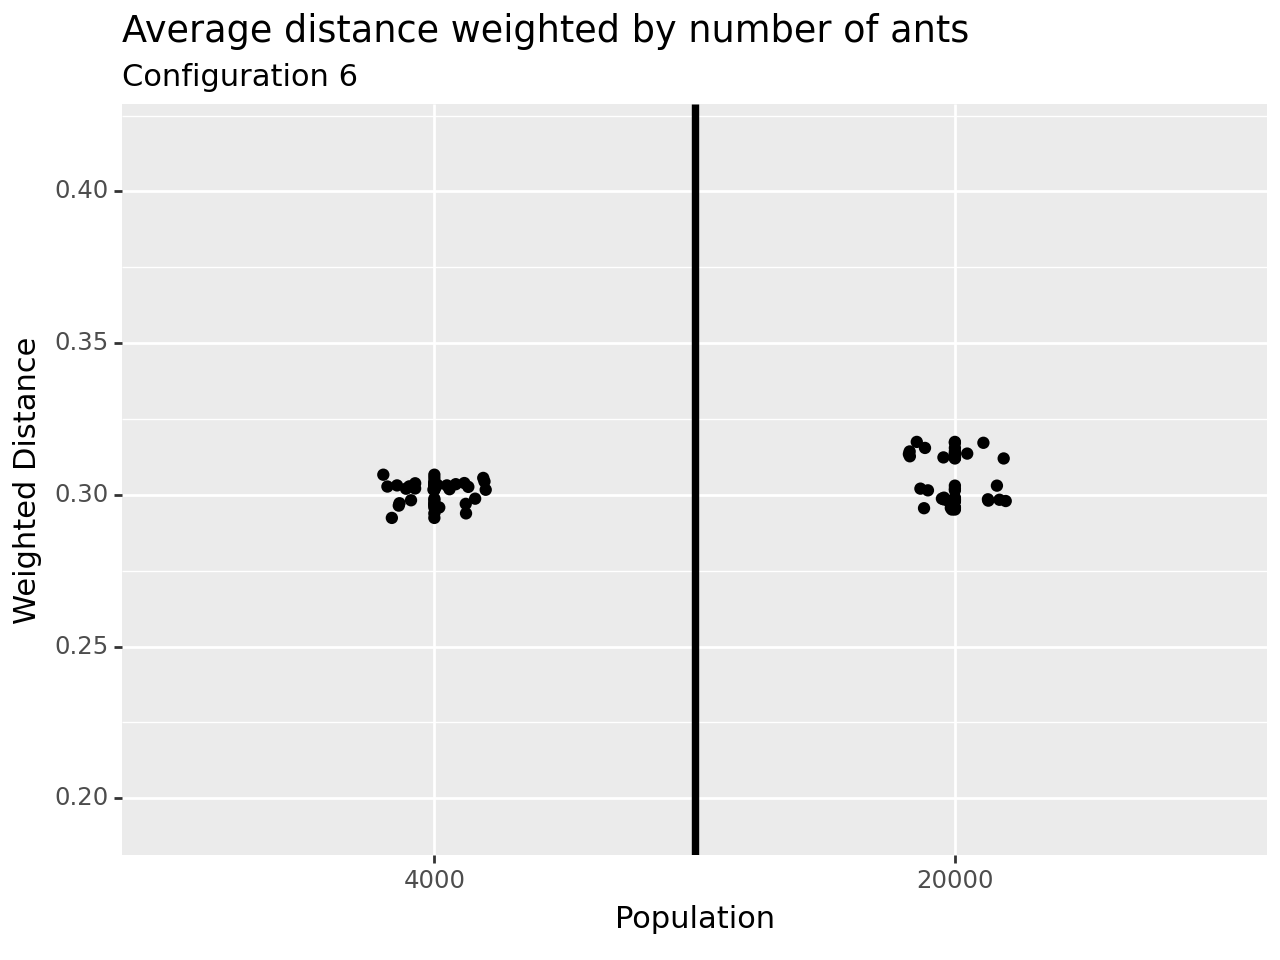

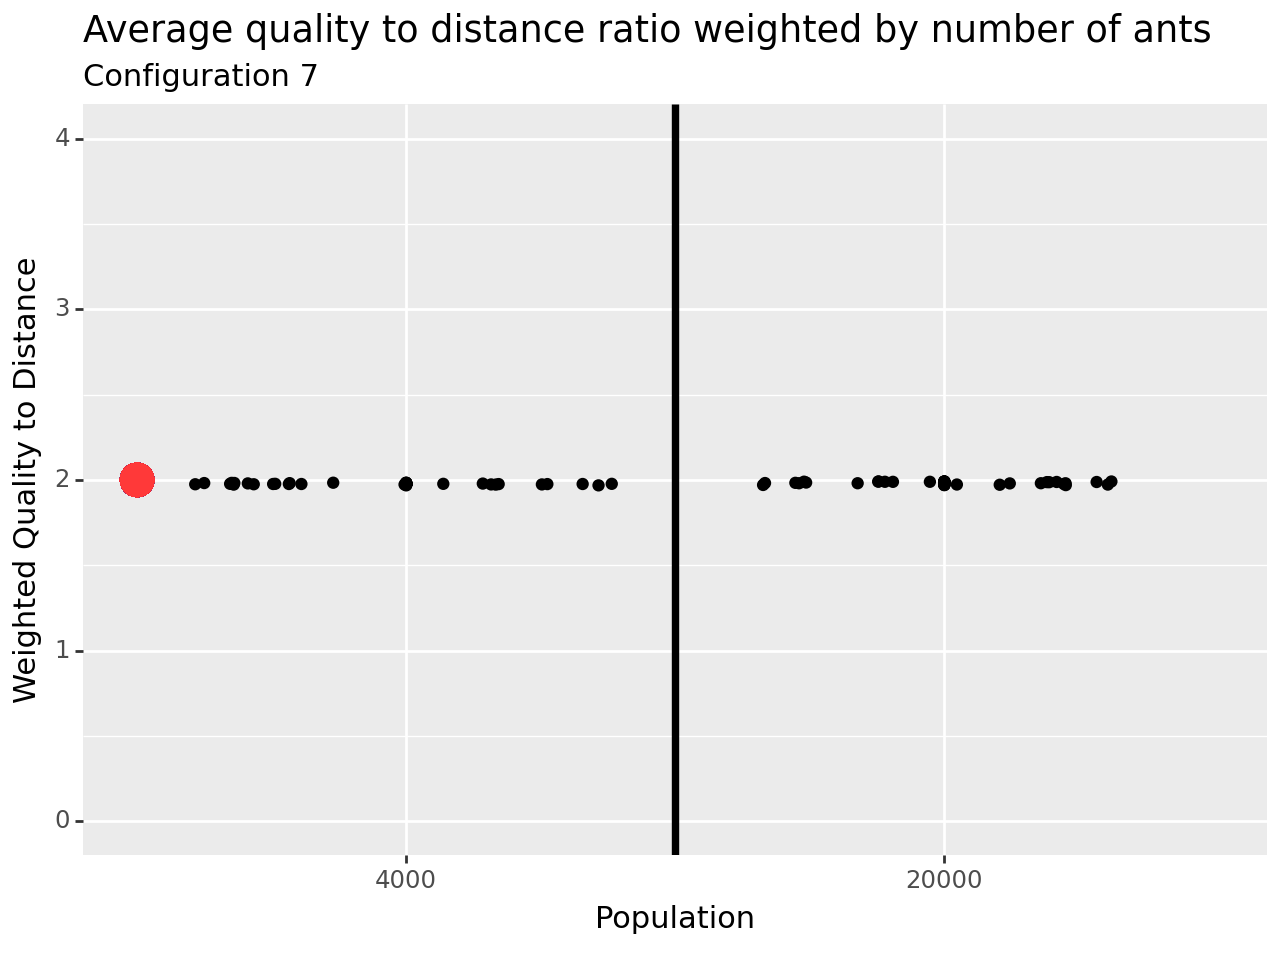

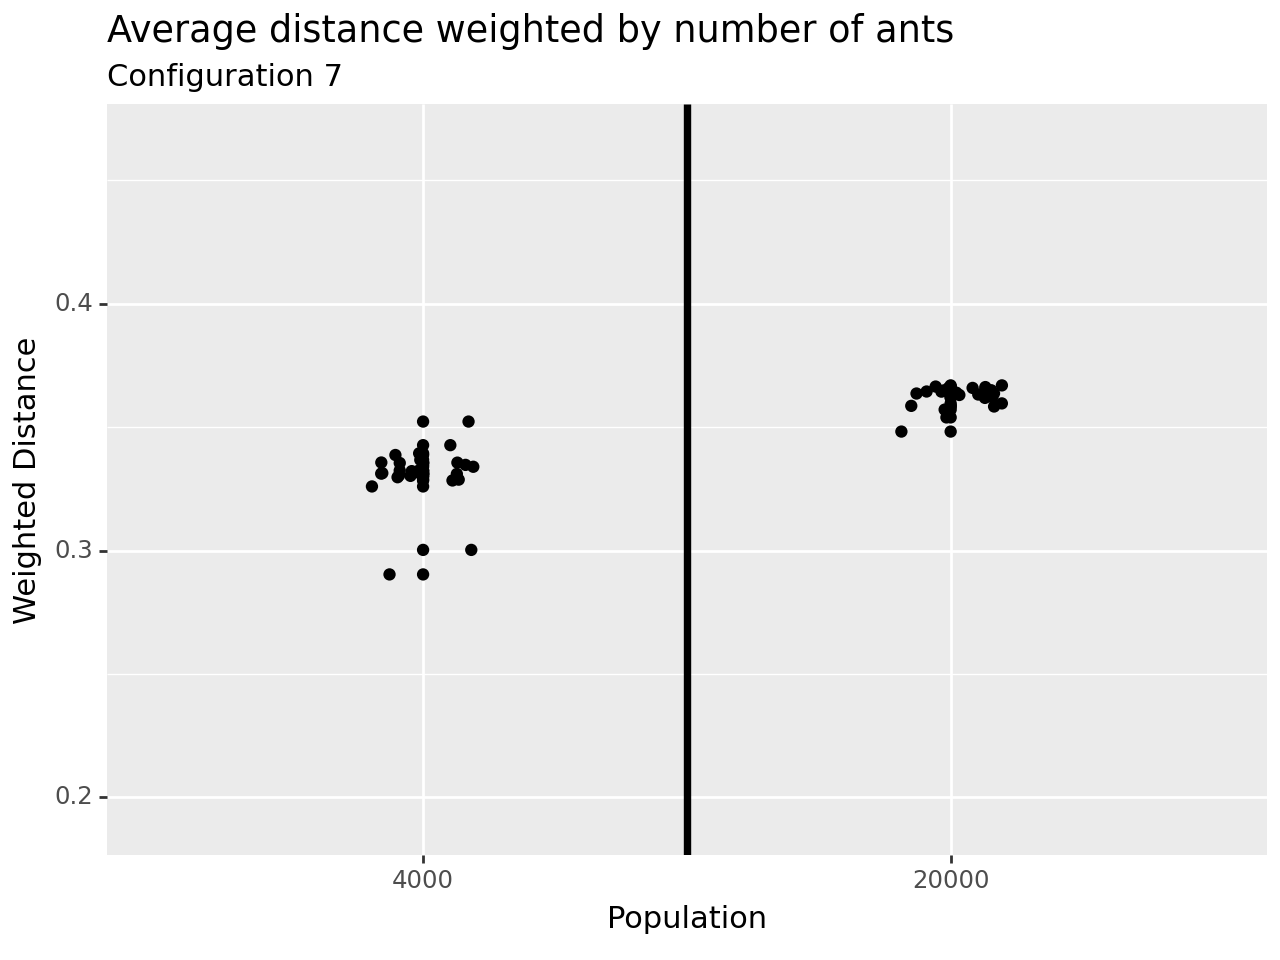

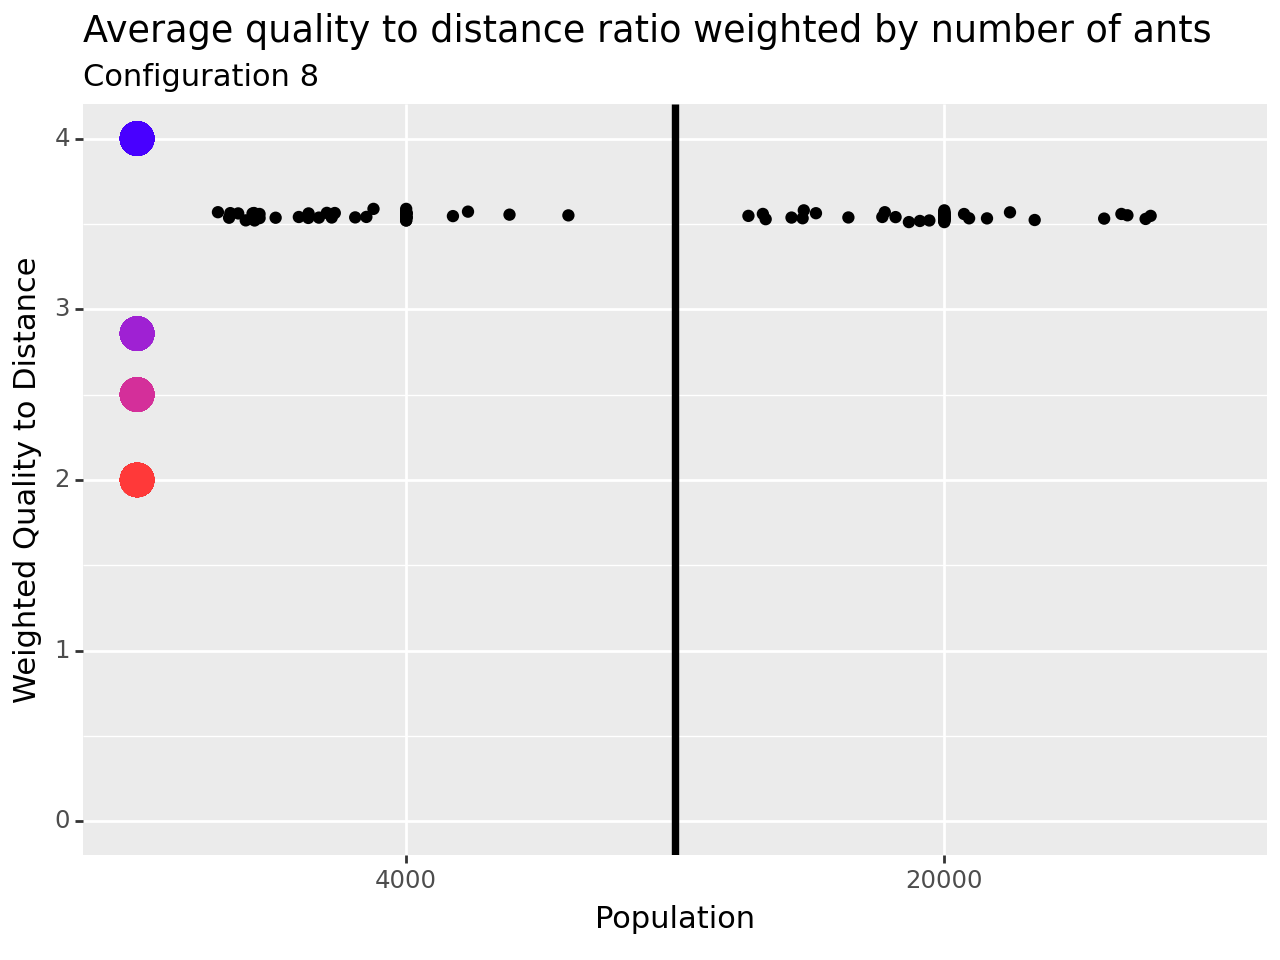

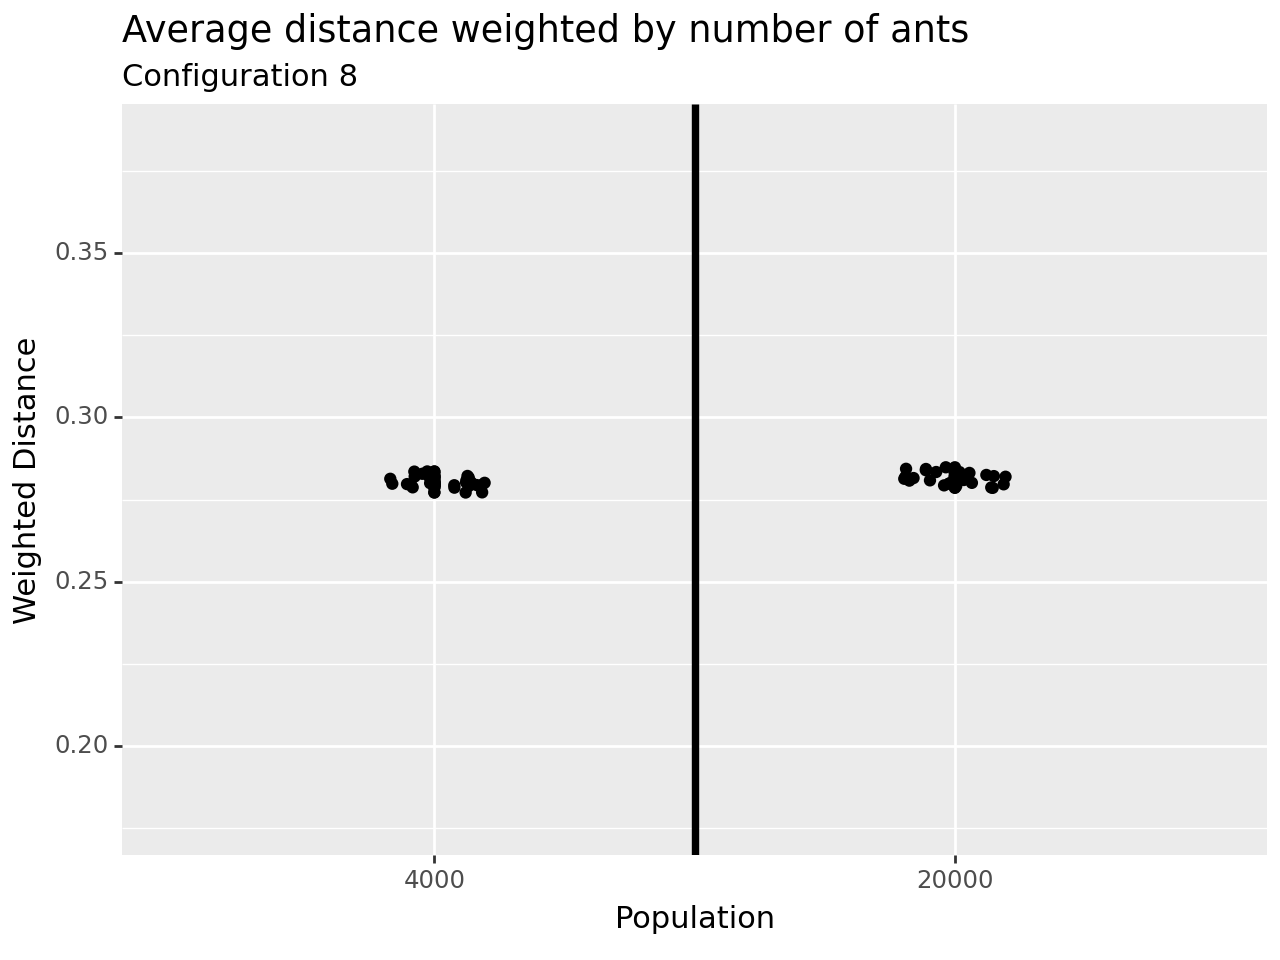

In [436]:

populations = [4000, 20000]
configs = [1,2,3,4,5,6,7,8]
for c in configs:
    d = {
        "population": [],
        "weighted-q-d" : [],
        "weighted-d" : []
    }
    for p in populations:
        results_path = fr"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\Pop_{p}\Config_{c}_{p}"
        results_files = [join(results_path,f) for f in listdir(results_path)]
        df = pd.read_csv(results_files[0])
        q_d = [0] * 4
        for i in range(4):
                q_d[i] += df.iloc[-1][f"pheromone-{i+1}"] / df.iloc[-1][f"distance-{i+1}"]
        q_d = sorted(q_d)
        
        for result in results_files:
            df = pd.read_csv(result)
            d["population"] += [str(p)]
            d["weighted-q-d"] += [0]
            d["weighted-d"] += [0]
            for i in range(4):
                d["weighted-q-d"][-1] += df.iloc[-1][f"source-{i+1}"]/p * df.iloc[-1][f"pheromone-{i+1}"] / df.iloc[-1][f"distance-{i+1}"]
                d["weighted-d"][-1] += df.iloc[-1][f"source-{i+1}"]/p * df.iloc[-1][f"distance-{i+1}"]
    
    df = pd.DataFrame(d)
    ggqd = (ggplot(df, aes(x="population", y="weighted-q-d")) 
          + geom_point()
          + geom_jitter(width = 0.4, height=0)
          + scale_x_discrete(limits=[str(x) for x in populations])
          + ylim([0,4])
          + geom_vline(xintercept=1.5, size=1.5)
          + geom_point(aes(x=.5, y = q_d[3]), color=cs[3], size=6)
          + geom_point(aes(x=.5, y = q_d[2]), color=cs[2], size=6)
          + geom_point(aes(x=.5, y = q_d[1]), color=cs[1], size=6)
          + geom_point(aes(x=.5, y = q_d[0]), color=cs[0], size=6)

          #+ geom_hline(yintercept=q_d[1], linetype="dashed", color=cs[1], size=2)
          #+ geom_hline(yintercept=q_d[2], linetype="dashed", color=cs[2], size=2)
          #+ geom_hline(yintercept=q_d[3], linetype="dashed", color=cs[3], size=2)
          + labs(title = "Average quality to distance ratio weighted by number of ants",
                subtitle = f"Configuration {c}")
          + xlab("Population")
          + ylab("Weighted Quality to Distance"))
    print(ggqd)
    ggd = (ggplot(df, aes(x="population", y="weighted-d")) 
          + geom_point()
          + geom_jitter(width = 0.1, height=0)
          + scale_x_discrete(limits=[str(x) for x in populations])
          + ylim([min(d["weighted-d"]) - 0.1,max(d["weighted-d"]) + 0.1])
          + geom_vline(xintercept=1.5, size=1.5)
          + labs(title = "Average distance weighted by number of ants",
                subtitle = f"Configuration {c}")
          + xlab("Population")
          + ylab("Weighted Distance"))
    print(ggd)


Create configuration plots

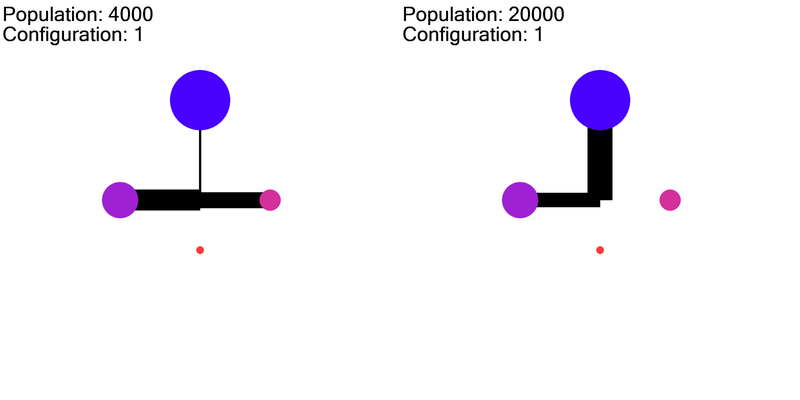

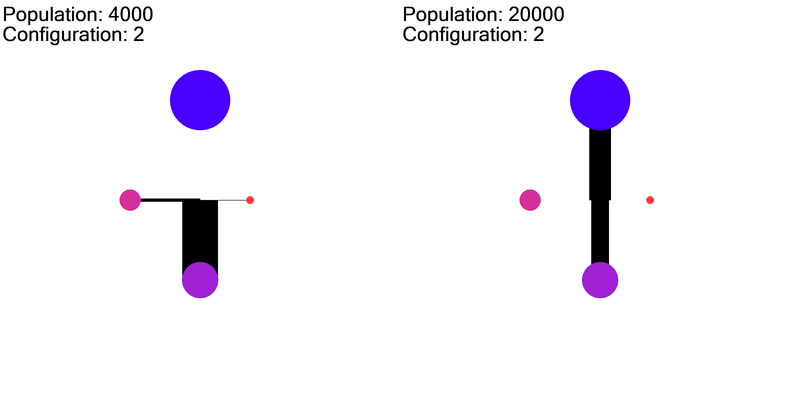

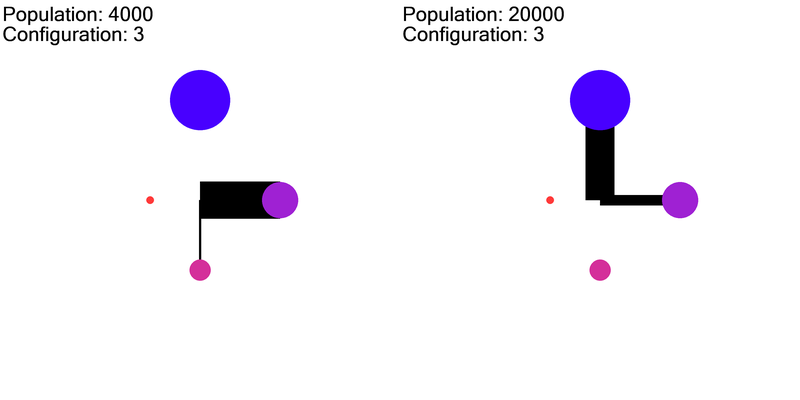

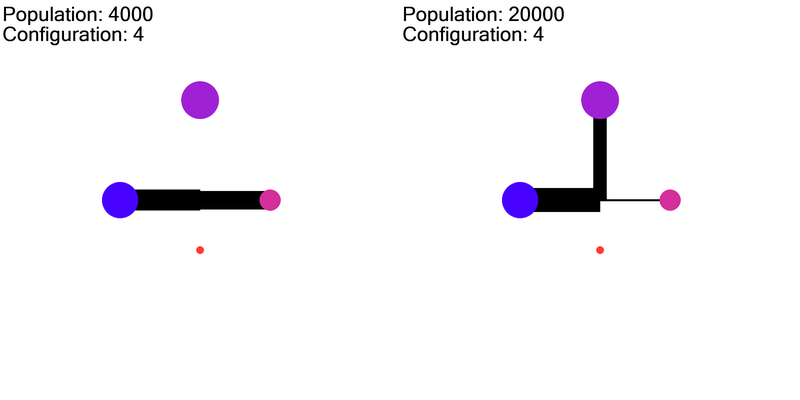

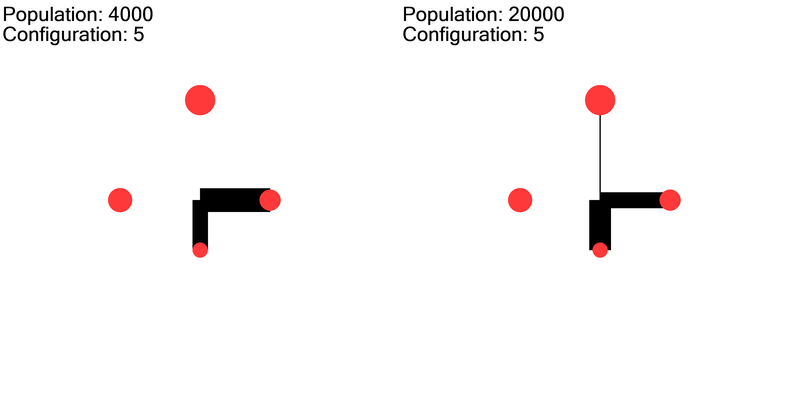

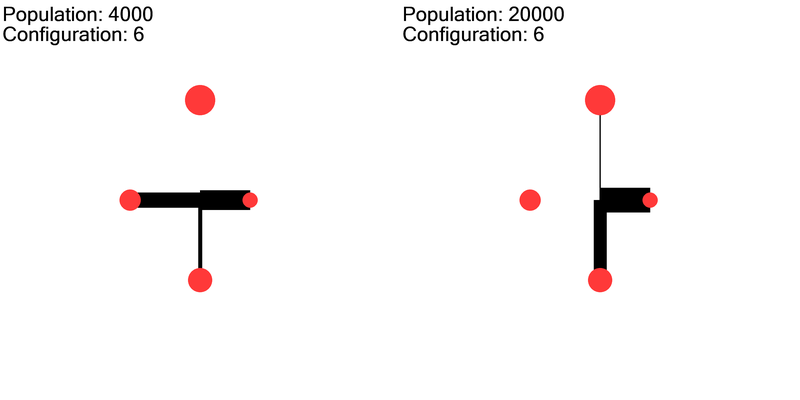

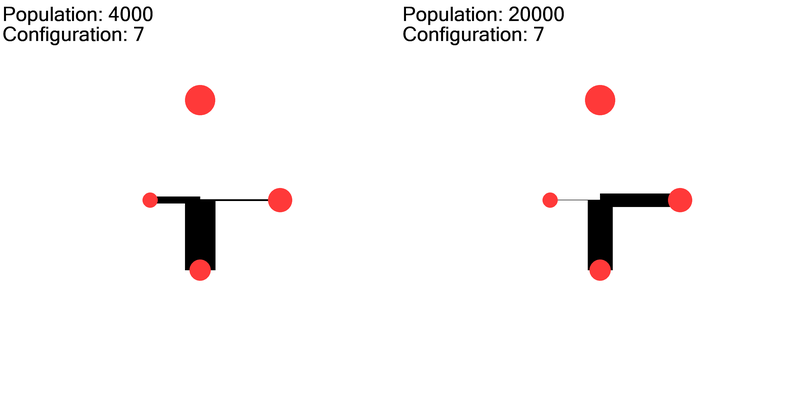

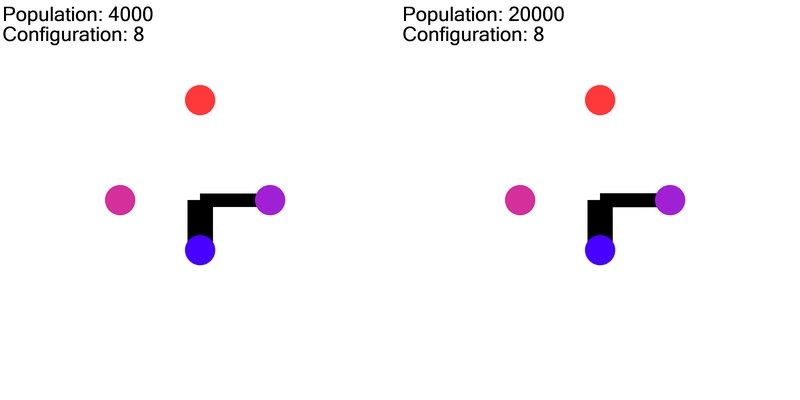

In [437]:
from PIL import Image, ImageDraw, ImageFont
from math import sin, cos, radians, floor

SUPERSAMPLE = 4

WIDTH = 400 * SUPERSAMPLE
HEIGHT = 400 * SUPERSAMPLE

C_X = WIDTH/2
C_Y = HEIGHT/2

TRAIL_SCALE = 40 * SUPERSAMPLE
QUALITY_SCALE = 15 * SUPERSAMPLE

FONT = ImageFont.truetype("C:\Windows\Fonts\micross.ttf", 20 * SUPERSAMPLE)

configs = [1,2,3,4,5,6,7,8]
populations = [4000,20000]

for c in configs:
    plots = []
    for p in populations:

        results_path = fr"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\Pop_{p}\Config_{c}_{p}"
        results_files = [join(results_path,f) for f in listdir(results_path)]
        d = {
            "distance": [0] * 4,
            "quality":  [0] * 4,
            "angle":    [0] * 4,
            "avg":      [0] * 4,
            "q-to-d":   [0] * 4
        }    
        
        #Get distance, quality, and angle data
        df = pd.read_csv(results_files[0])
        for i in range(4):
            d["distance"][i] = df.iloc[0][f"distance-{i+1}"]
            d["quality"][i]  = df.iloc[0][f"pheromone-{i+1}"]
            d["angle"][i] = radians(90 * (1-i))
            d["q-to-d"][i] = d["quality"][i] / d["distance"][i]
        sorted_q_d = sorted(d["q-to-d"])
        
        #Get average data
        for result in results_files:
            df = pd.read_csv(result)
            for i in range(4):
                d["avg"][i] += df.iloc[-1][f"source-{i+1}"] / (p * len(results_files))        
        
        #Create the plot
        plot = Image.new(mode = "RGB", size = (WIDTH, HEIGHT), color=(255, 255, 255))
        draw = ImageDraw.Draw(plot)

        for i in range(4):
            angle = d["angle"][i]
            dist = d["distance"][i]
            food_X = cos(angle) * dist * C_X
            food_Y = sin(angle) * dist * C_Y
           
            if floor(d["avg"][i] * TRAIL_SCALE) > 1:
                #Draw the scaled lines
                draw.line([(C_X, C_Y), (C_X + food_X, C_Y - food_Y)], width = floor(TRAIL_SCALE * d["avg"][i]), fill=(0,0,0))

            #Draw the scaled and colored circles
            qual = d["quality"][i]
            draw.ellipse([(C_X + food_X - QUALITY_SCALE * qual, C_Y - food_Y - QUALITY_SCALE * qual), 
                          (C_X + food_X + QUALITY_SCALE * qual, C_Y - food_Y + QUALITY_SCALE * qual)], 
                         fill=cs[sorted_q_d.index(qual/dist)])
            
            #Labeling
            draw.text((10,10), f"Population: {p}", (0, 0, 0), font=FONT)
            draw.text((10, 10 + 20 * SUPERSAMPLE), f"Configuration: {c}", (0, 0, 0), font=FONT)
        plots += [plot]
            
            
    #Combine into one plot and display
    final_plot = Image.new('RGB', (len(populations)*WIDTH, HEIGHT))
    for i in range(len(plots)):
        final_plot.paste(plots[i], (WIDTH*i, 0))
    final_plot = final_plot.resize((WIDTH*len(populations)//SUPERSAMPLE, HEIGHT//SUPERSAMPLE), resample=Image.LANCZOS)
    display(final_plot)

Using Behavior Space Now

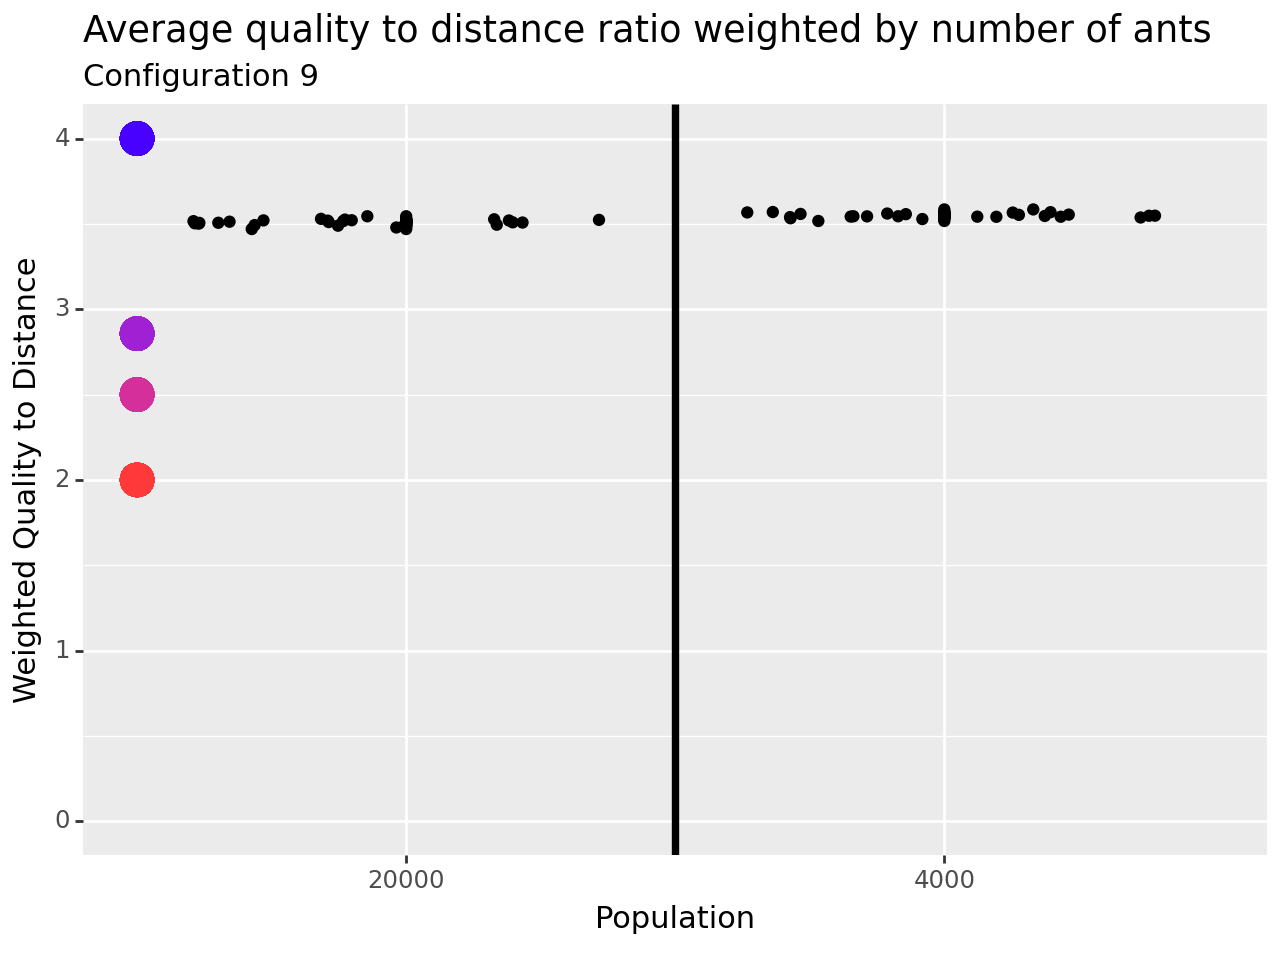

<Figure Size: (640 x 480)>

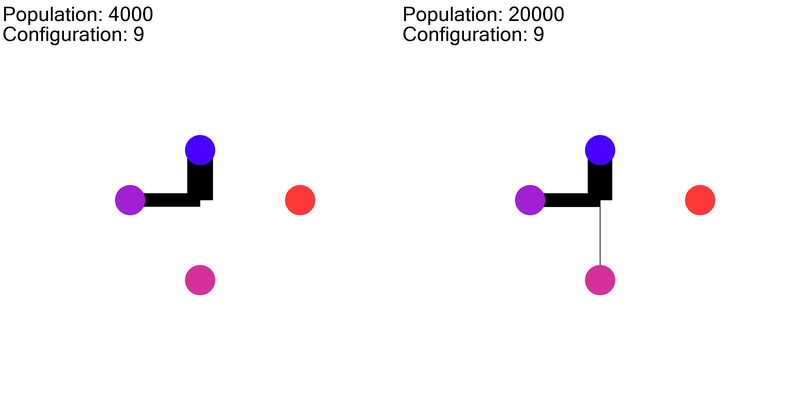

In [463]:
from PIL import Image, ImageDraw, ImageFont
from math import sin, cos, radians, floor

SUPERSAMPLE = 4

WIDTH = 400 * SUPERSAMPLE
HEIGHT = 400 * SUPERSAMPLE

C_X = WIDTH/2
C_Y = HEIGHT/2

TRAIL_SCALE = 40 * SUPERSAMPLE
QUALITY_SCALE = 15 * SUPERSAMPLE

FONT = ImageFont.truetype("C:\Windows\Fonts\micross.ttf", 20 * SUPERSAMPLE)


configurations = [9]
for c in configurations:
    plots = []
    results_path = fr"C:\Users\zbtra\Documents\Sophomore\Spring\Research\AntForagingModel\ABResults\BehaviorSpaceTest\config{c}.csv"
    df = pd.read_csv(results_path, header=6, index_col=0)
    df.fillna(method = 'ffill', inplace=True, axis='columns')

    #Calculate weighted quality to distance and average proportion of ants at each source at the final time
    w_q_d = np.zeros(df.shape[1]//4)
    
    for i in range(1,5):
        source_i = df.iloc[:, (i-1)::4]
        w_q_d += np.array(source_i.loc[f"pheromone-{i}"].astype(float) / source_i.loc[f"distance-{i}"].astype(float) * source_i.loc["[final]"].astype(float) / source_i.loc[f"population"].astype(float))
    #pf = df.loc[:, df.eq("4000").loc["population"]]

    d = {
        "population": df.iloc[:, 0::4].loc["population"],
        "weighted-q-d": w_q_d    }

    df_avg = pd.DataFrame(d)
    ggqd = (ggplot(df_avg, aes(x="population", y="weighted-q-d")) 
          + geom_point()
          + geom_jitter(width = 0.4, height=0)
          + ylim([0,4])
          + geom_vline(xintercept=1.5, size=1.5)
          + geom_point(aes(x=.5, y = q_d[3]), color=cs[3], size=6)
          + geom_point(aes(x=.5, y = q_d[2]), color=cs[2], size=6)
          + geom_point(aes(x=.5, y = q_d[1]), color=cs[1], size=6)
          + geom_point(aes(x=.5, y = q_d[0]), color=cs[0], size=6)
          + labs(title = "Average quality to distance ratio weighted by number of ants",
                subtitle = f"Configuration {c}")
          + xlab("Population")
          + ylab("Weighted Quality to Distance"))
    display(ggqd)
    runs = df.shape[1] // df.loc["population"].nunique()
    for p in range(df.loc["population"].nunique()):
        d = {
            "distance": [0] * 4,
            "quality":  [0] * 4,
            "angle":    [0] * 4,
            "avg":      [0] * 4,
            "q-to-d":   [0] * 4
        }
        for i in range(1,5):
            d["avg"][i-1] = df.iloc[:, p * runs + (i-1):(p+1) * runs:4].loc["[final]"].astype(float).sum()/(runs // 4) / float(df.loc["population"].unique()[p])  
            d["distance"][i-1] = float(df["1"][f"distance-{i}"])
            d["quality"][i-1]  = float(df["1"][f"pheromone-{i}"])
            d["angle"][i-1] = radians(90 * (1-i))
            d["q-to-d"][i-1] = d["quality"][i-1] / d["distance"][i-1]
        sorted_q_d = sorted(d["q-to-d"])
    
        #Create the plot
        plot = Image.new(mode = "RGB", size = (WIDTH, HEIGHT), color=(255, 255, 255))
        draw = ImageDraw.Draw(plot)
        for i in range(4):
            angle = d["angle"][i]
            dist = d["distance"][i]
            food_X = cos(angle) * dist * C_X
            food_Y = sin(angle) * dist * C_Y
            if floor(d["avg"][i] * TRAIL_SCALE) > 1:
                #Draw the scaled lines
                draw.line([(C_X, C_Y), (C_X + food_X, C_Y - food_Y)], width = floor(TRAIL_SCALE * d["avg"][i]), fill=(0,0,0))

            #Draw the scaled and colored circles
            qual = d["quality"][i]
            draw.ellipse([(C_X + food_X - QUALITY_SCALE * qual, C_Y - food_Y - QUALITY_SCALE * qual), 
                          (C_X + food_X + QUALITY_SCALE * qual, C_Y - food_Y + QUALITY_SCALE * qual)], 
                         fill=cs[sorted_q_d.index(qual/dist)])
            
        #Labeling
        draw.text((10,10), f"Population: {df.loc['population'].unique()[p]}", (0, 0, 0), font=FONT)
        draw.text((10, 10 + 20 * SUPERSAMPLE), f"Configuration: {c}", (0, 0, 0), font=FONT)
        plots += [plot]
            
            
    #Combine into one plot and display
    final_plot = Image.new('RGB', (len(populations)*WIDTH, HEIGHT))
    for i in range(len(plots)):
        final_plot.paste(plots[i], (WIDTH*i, 0))
    final_plot = final_plot.resize((WIDTH*len(populations)//SUPERSAMPLE, HEIGHT//SUPERSAMPLE), resample=Image.LANCZOS)
    display(final_plot)